In [ ]:
!pip install torchmetrics


In [ ]:
!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=b16ab1f2f05c819308abc6ca2ac47855b0c2e385c4e430f3f7baa6a81a40c1bc
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ISIC 2019 dataset

In [ ]:
import pandas as pd

groundtruth = pd.read_csv("../content/ISIC2019/ISIC_2019_Training_Input/ISIC_2019_Training_GroundTruth.csv")
groundtruth = groundtruth.set_index("image")
indist = list(groundtruth.index)

In [ ]:
from pathlib import Path

folder_dir = "../content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
images_ISIC = list(Path(folder_dir).glob("*.jpg"))

# Print the number of training images
print("Number of training images:", len(images_ISIC))


Number of training images: 25331


In [ ]:
#upload ISIC data to drive (this is another kaggle source)
from pathlib import Path
import shutil


dest_dir ="/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
folder_dir = "../content/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
images_ISIC = list(Path(folder_dir).glob("*.jpg"))


#Copy ISIC  images to the destination directory
for i in images_ISIC:
    shutil.copy(i, dest_dir)

# FitzPatrick 17k dataset

In [ ]:
from pathlib import Path
import shutil

folder_dir_dark = "../content/fitzpatrick 17k /Darker_Only/Darker_Skin_Tones"
folder_dir_light = "../content/fitzpatrick 17k /Lighter_only/Lighter_Skin_Tones"
dest_all_dir = "../content/All images"

# Collect image paths from both directories
images_dark = list(Path(folder_dir_dark).glob("*.jpg"))
images_light = list(Path(folder_dir_light).glob("*.jpg"))
images_all = images_dark + images_light

# Copy all images to the destination directory
#for i in all_images:
 #   shutil.copy(i, dest_all_dir)



In [ ]:
print (len(images_all))
print (len(images_dark))
print (len(images_light))

12222
1318
10904


## Creating a simple Autoencoder

In [ ]:
import torch
from ae import Autoencoder
from torchsummary import summary

ae = Autoencoder()

if torch.cuda.is_available():
    ae = ae.cuda()
summary(ae, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 16, 16]             588
              ReLU-2           [-1, 12, 16, 16]               0
            Conv2d-3             [-1, 24, 8, 8]           4,632
              ReLU-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 48, 4, 4]          18,480
              ReLU-6             [-1, 48, 4, 4]               0
   ConvTranspose2d-7             [-1, 24, 8, 8]          18,456
              ReLU-8             [-1, 24, 8, 8]               0
   ConvTranspose2d-9           [-1, 12, 16, 16]           4,620
             ReLU-10           [-1, 12, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             579
          Sigmoid-12            [-1, 3, 32, 32]               0
Total params: 47,355
Trainable params: 47,355
Non-trainable params: 0
---------------------------------

## Get the images ready for the Ae

In [ ]:
from torchvision import transforms as tfs

transforms_train = [
    tfs.RandomHorizontalFlip(p=0.5),
    # tfs.RandomAutocontrast(p=0.5),
    # tfs.RandomAdjustSharpness(p=0.5, sharpness_factor=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((16, 16)),
    # tfs.Grayscale(1),
    tfs.ToTensor(),
    # tfs.Normalize(mean=0.46 ,std=0.32)
]

transforms_test = [
    tfs.Resize((16, 16)),
    # tfs.Grayscale(1),
    tfs.ToTensor(),
    # tfs.Normalize(mean=0.46 ,std=0.32)
]

In [ ]:
#splitting the tain data
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

train_data_path = "../content/ISIC2019/ISIC_2019_Training_Input"


image_data_train = ImageFolder(train_data_path, transform=tfs.Compose(transforms_train))

total_size = len(image_data_train)
train_size = int(0.8 * total_size)  # 80% for training
valid_size = total_size - train_size

# Split the dataset into training and validation sets
train_dataset, valid_dataset = random_split(image_data_train, [train_size, valid_size])

In [ ]:
#for ALL
image_data_test_ALL = ImageFolder( "/content/Datasets/dataset/ALL_images", transform=tfs.Compose(transforms_test))

In [ ]:
#for darker only
image_data_test_darker = ImageFolder( "../content/Datasets/dataset/fitzpatrick 17k /Darker_Only", transform=tfs.Compose(transforms_test))


#for lighter only
image_data_test_lighter = ImageFolder("../content/Datasets/dataset/fitzpatrick 17k /Lighter_only", transform=tfs.Compose(transforms_test))



In [ ]:
image_data_train.classes

['ISIC_2019_Training_Input']

In [ ]:
print(image_data_test_ALL.classes)
print(image_data_test_darker.classes)
print(image_data_test_lighter.classes)

['All images']
['Darker_Skin_Tones']
['Lighter_Skin_Tones']


# Data loaders

In [ ]:
#data_loader_train = DataLoader(image_data_train, batch_size=100, shuffle=True)  #ISIC as in distribution
data_loader_test_ALL = DataLoader(image_data_test_ALL, batch_size=100, shuffle=True) #Fitz as out distribution ALL
data_loader_test_Darker = DataLoader(image_data_test_darker, batch_size=100, shuffle=True) #darker only
data_loader_test_Lighter = DataLoader(image_data_test_lighter , batch_size=100 , shuffle=True ) #lighter only

In [ ]:
# Create DataLoaders for training and validation
batch_size = 100
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_loader_validation = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0])


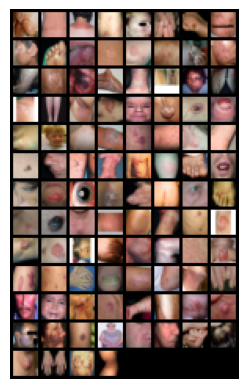

In [ ]:
from aux import create_plot_window
from aux import imshow
import torchvision


dataiter = iter(data_loader_test)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


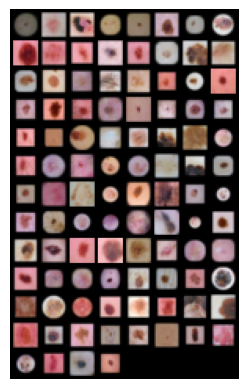

In [ ]:
#from aux import create_plot_window , imshow
from aux import create_plot_window
from aux import imshow


import torchvision

dataiter = iter(data_loader_train)
images_in, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images_in))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


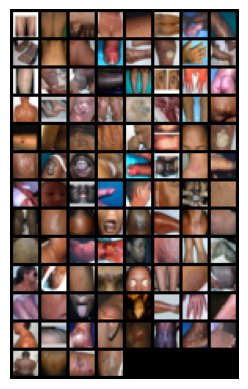

In [ ]:
from aux import create_plot_window
from aux import imshow
import torchvision


dataiter = iter(data_loader_test_Darker)
images_dark, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images_dark))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


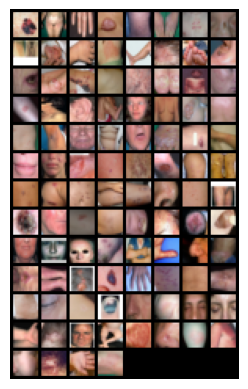

In [ ]:
from aux import create_plot_window
from aux import imshow
import torchvision


dataiter = iter(data_loader_test_Lighter)
images_light, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images_light))

## Model training



In [ ]:
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import torchmetrics

device = "cpu"

ae = Autoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.0001, betas=(0.5, 0.999))

if torch.cuda.is_available():
    ae = ae.cuda()
    criterion = criterion.cuda()

### Apply early stopping

In [ ]:
from aux import get_torch_vars



epochs = 100
patience = 5  # Number of epochs to wait for early stopping
best_valid_loss = float('inf')
early_stopping_counter = 0


train_losses = []
valid_losses = []

for epoch in range(epochs):
    ae.train()
    running_loss = 0.0

    for i, (inputs, _) in enumerate(data_loader_train, 0):
        inputs = get_torch_vars(inputs)

        # Forward Pass
        encoded, outputs = ae(inputs)
        loss = criterion(outputs, inputs)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(data_loader_train)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {avg_train_loss:.4f}")

    # Validation
    ae.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for inputs, _ in data_loader_validation :
            inputs = get_torch_vars(inputs)
            encoded, outputs = ae(inputs)
            loss = criterion(outputs, inputs)
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(data_loader_validation )
    valid_losses.append(avg_valid_loss)

    print(f"Validation Loss: {avg_valid_loss:.4f}")

    # Early stopping
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping. No improvement in validation loss.")
        break



Epoch [1/100] - Train Loss: 0.6532
Validation Loss: 0.6189
Epoch [2/100] - Train Loss: 0.6007
Validation Loss: 0.5790
Epoch [3/100] - Train Loss: 0.5502
Validation Loss: 0.5354
Epoch [4/100] - Train Loss: 0.5286
Validation Loss: 0.5262
Epoch [5/100] - Train Loss: 0.5214
Validation Loss: 0.5193
Epoch [6/100] - Train Loss: 0.5152
Validation Loss: 0.5141
Epoch [7/100] - Train Loss: 0.5111
Validation Loss: 0.5081
Epoch [8/100] - Train Loss: 0.5061
Validation Loss: 0.5043
Epoch [9/100] - Train Loss: 0.5050
Validation Loss: 0.5036
Epoch [10/100] - Train Loss: 0.5014
Validation Loss: 0.4996
Epoch [11/100] - Train Loss: 0.4991
Validation Loss: 0.5011
Epoch [12/100] - Train Loss: 0.4995
Validation Loss: 0.4994
Epoch [13/100] - Train Loss: 0.4942
Validation Loss: 0.4970
Epoch [14/100] - Train Loss: 0.4952
Validation Loss: 0.4966
Epoch [15/100] - Train Loss: 0.4928
Validation Loss: 0.4951
Epoch [16/100] - Train Loss: 0.4934
Validation Loss: 0.4934
Epoch [17/100] - Train Loss: 0.4921
Validation Lo

#### Plot the losses:

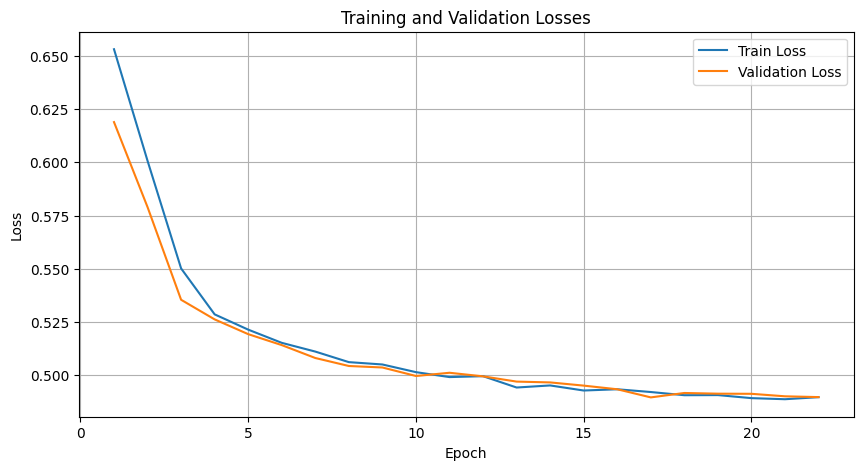

In [ ]:
# Plot training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

#### Save the weights

In [ ]:
import os

save_dir = "./weights"

os.makedirs(save_dir, exist_ok=True)

torch.save(ae.state_dict(), os.path.join(save_dir, "autoencoder.pkl"))

#### Loading the saved weights

In [ ]:
ae = Autoencoder()
ae.load_state_dict(torch.load("/content/autoencoder.pkl", map_location="cpu"))

<All keys matched successfully>

## Plot the train data econstructed samples

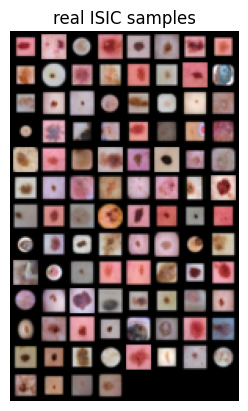

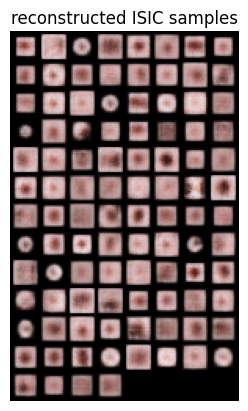

In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
from aux import create_plot_window
from aux import imshow
import torchvision

dataiter = iter(data_loader_train)
images_ISIC, labels = next(dataiter)

plt.title("real ISIC samples")
imshow(torchvision.utils.make_grid(images_ISIC))

images = Variable(images_ISIC)
labels, decoded_imgs = ae(images)
plt.title("reconstructed ISIC samples")
imshow(torchvision.utils.make_grid(decoded_imgs.data))

## Use the trained model on the Fitz dataset :

ALL

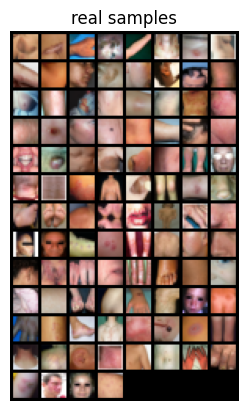

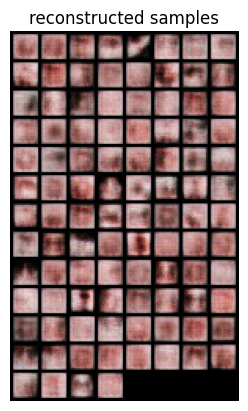

In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

dataiter = iter(data_loader_test)#ALL
images, labels = next(dataiter)

plt.title("real samples")
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
labels, decoded_imgs = ae(images)
plt.title("reconstructed samples")
imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

Lighter_samples = []
Darker_samples = []

for images, labels in data_loader_test:
    labels = labels.numpy()  # Convert labels tensor to a NumPy array
    if np.any(labels == 1):
        Darker_samples.append((images, labels))
    elif np.any(labels == 0):
        Lighter_samples.append((images, labels))
batch_size = 100
#Lighter_data_loader = DataLoader(Lighter_samples, batch_size=batch_size, shuffle=True)
Darker_data_loader = DataLoader(Darker_samples, batch_size=batch_size, shuffle=True)



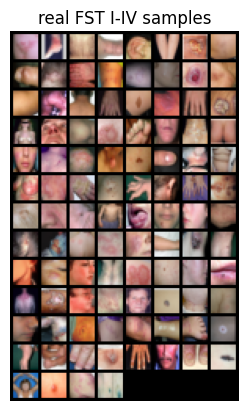

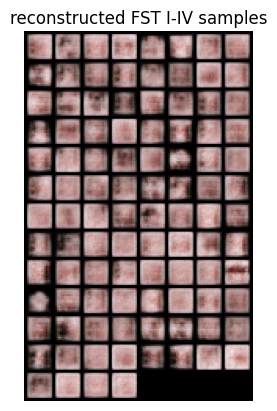

In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
from aux import create_plot_window
from aux import imshow
import torchvision



dataiter = iter(data_loader_test_Lighter)#Lighter only
images_light, labels = next(dataiter)

plt.title("real FST I-IV samples")
imshow(torchvision.utils.make_grid(images_light))

images = Variable(images_light)
labels, decoded_imgs = ae(images_light)
plt.title("reconstructed FST I-IV samples")
imshow(torchvision.utils.make_grid(decoded_imgs.data))

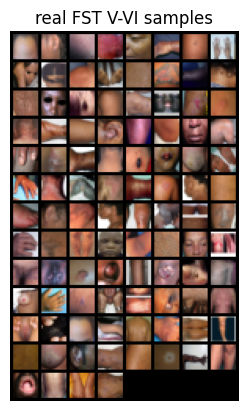

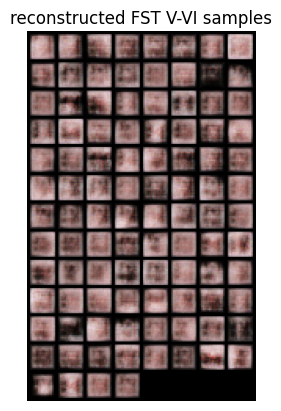

In [ ]:
dataiter = iter(data_loader_test_Darker)#Darker only
images_dark, labels = next(dataiter)

plt.title("real FST V-VI samples")
imshow(torchvision.utils.make_grid(images_dark))

images_dark= Variable(images_dark)
labels, decoded_imgs = ae(images_dark)
plt.title("reconstructed FST V-VI samples")
imshow(torchvision.utils.make_grid(decoded_imgs.data))

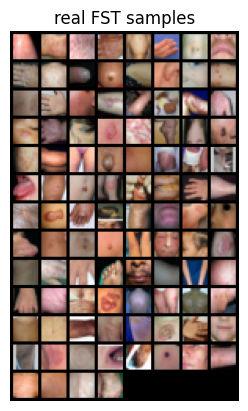

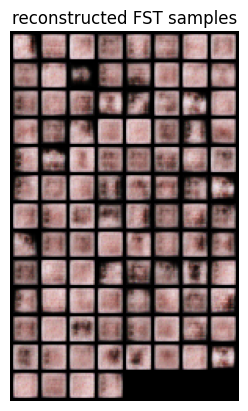

In [ ]:
dataiter = iter(data_loader_test_ALL)#ALL
images_all, labels = next(dataiter)

plt.title("real FST samples")
imshow(torchvision.utils.make_grid(images_all))

images_all= Variable(images_all)
labels, decoded_imgs = ae(images_all)
plt.title("reconstructed FST samples")
imshow(torchvision.utils.make_grid(decoded_imgs.data))

## Measuring the reconstruction error

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
mse = nn.MSELoss(reduction="sum")
mse_test = list()
labels_test = list()



In [ ]:
mse_train = list()
labels_train = list()
reconstructed_inputs_train = list()

for i, (inputs, labels) in enumerate(data_loader_train, 0):
    for j in range(inputs.shape[0]):
        # No need for Variable, work directly with tensors
        images_ISIC = inputs
        decoded_imgs = ae(images_ISIC)[1]#[1]
        mse_train.append(mse(decoded_imgs[j], images_ISIC[j]).item())
        labels_train.append(labels[j].detach().numpy().item())
        reconstructed_inputs_train.append(images_ISIC[j].detach().numpy())


In [ ]:
#For all
mse = nn.MSELoss(reduction="sum")
mse_test_All = list()
labels_test_All = list()
reconstructed_inputs_test_All = list()

for i, (inputs, labels) in enumerate(data_loader_test_ALL, 0):
    for j in range(inputs.shape[0]):
        # print(inputs.shape)
        images_all = inputs
        decoded_imgs = ae(images_all)[1]#[1]
        mse_test_All.append(mse(decoded_imgs[j], images_all[j]).item())
        labels_test_All.append(labels[j].detach().numpy().item())
        reconstructed_inputs_test_All.append(images_all[j].detach().numpy())



In [ ]:
mse = nn.MSELoss(reduction="sum")
mse_test_dark = list()
labels_test_dark = list()
reconstructed_inputs_test_dark = list()
for i, (inputs, labels) in enumerate(data_loader_test_Darker, 0):
    for j in range(inputs.shape[0]):
        # print(inputs.shape)
        images_dark = inputs
        decoded_imgs = ae(images_dark)[1]#[1]
        mse_test_dark.append(mse(decoded_imgs[j], images_dark[j]).item())
        labels_test_dark.append(labels[j].detach().numpy().item())
        reconstructed_inputs_test_dark.append(images_dark[j].detach().numpy())

In [ ]:
mse = nn.MSELoss(reduction="sum")
mse_test_light = list()
labels_test_light = list()
reconstructed_inputs_test_light = list()

for i, (inputs, labels) in enumerate(data_loader_test_Lighter, 0):
    for j in range(inputs.shape[0]):
        # print(inputs.shape)
        images_light = inputs
        decoded_imgs = ae(images_light)[1]#[1]
        mse_test_light.append(mse(decoded_imgs[j], images_light[j]).item())
        labels_test_light.append(labels[j].detach().numpy().item())
        reconstructed_inputs_test_light.append(images_light[j].detach().numpy())

## Saving reconstructed errors and inputs

In [ ]:
import numpy as np

mse_train = np.array(mse_train)
labels_train = np.array(labels_train)
reconstructed_inputs_train = np.array(reconstructed_inputs_train)


mse_test_light = np.array(mse_test_light)
labels_test_light = np.array(mse_test_light)
reconstructed_inputs_test_light = np.array(reconstructed_inputs_test_light )


mse_test_dark = np.array(mse_test_dark)
labels_test_dark = np.array(labels_test_dark)
reconstructed_inputs_test_dark = np.array(reconstructed_inputs_test_dark)


# Save training data
np.save("mse_train.npy", mse_train)
np.save("labels_train.npy", labels_train)
np.save("reconstructed_inputs_train.npy", reconstructed_inputs_train)

# Save test data for light
np.save("mse_test_light.npy", mse_test_light)
np.save("labels_test_light.npy", labels_test_light)
np.save("reconstructed_inputs_test_light.npy", reconstructed_inputs_test_light)

# Save test data for dark
np.save("mse_test_dark.npy", mse_test_dark)
np.save("labels_test_dark.npy", labels_test_dark)
np.save("reconstructed_inputs_test_dark.npy", reconstructed_inputs_test_dark)

In [ ]:
#assert len(labels_test_All) == len(mse_test_All)
assert len(labels_test_dark) == len(mse_test_dark)
assert len(labels_test_light) == len(mse_test_light)
assert len(labels_train) == len(mse_train)

In [ ]:
#print(len(labels_test_All))
print(len(labels_test_dark))
print(len(labels_test_light))
print(len(labels_train))



1318
10904
20264


In [ ]:
import pandas as pd
import numpy as np

#error_df_All = pd.DataFrame({"re": mse_test_All, "labels": labels_test_All})#all
error_df_dark = pd.DataFrame({"re": mse_test_dark, "labels": labels_test_dark})
error_df_light = pd.DataFrame({"re": mse_test_light, "labels": labels_test_light})
error_df_train = pd.DataFrame({"re": mse_train, "labels": labels_train})

In [ ]:
error_df_dark["labels"] = 2  # Assign label 2 to dark
error_df_light["labels"] = 1  # Assign label 1 to light
error_df_train["labels"] = 0  # Assign label 0 to train

# Concatenate the DataFrames into one
error_df = pd.concat([error_df_train, error_df_light, error_df_dark], ignore_index=True)
error_df= error_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#Concate train and test ALL as one dataframe
error_df_All["labels"] = 1
error_df_train["labels"] = 0

error_df1 = pd.concat([error_df_train,error_df_All], ignore_index=True)
error_df1= error_df1.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
error_df1

,re,labels
0,4.342609,0
1,4.265398,0
2,4.080728,0
3,4.513561,1
4,10.046871,0
...,...,...
32481,19.749836,1
32482,2.297856,0
32483,2.614737,0
32484,4.884062,0


In [ ]:
#print(error_df)
#print(error_df_dark)
#print(error_df_light)
error_df

,re,labels
0,4.342609,0
1,4.265398,0
2,4.080728,0
3,24.960615,2
4,10.046871,0
...,...,...
32481,44.714958,1
32482,2.297856,0
32483,2.614737,0
32484,4.884062,0


## Build a dummy theshold between the outliers distributions and the in-distribution samples


In [ ]:
from scipy.stats import gaussian_kde

x = np.arange(0, 100)
t = gaussian_kde(error_df.re[error_df.labels == 0].values)
#e = gaussian_kde(error_df.re[error_df.labels == 0].values)
f = gaussian_kde(error_df.re[error_df.labels == 2].values)
g = gaussian_kde(error_df.re[error_df.labels == 1].values)
idxs_L = np.argwhere(np.diff(np.sign(t(x) - g(x)))).flatten()#for light only
idxs_D = np.argwhere(np.diff(np.sign(t(x) - f(x)))).flatten()#for dark only


In [ ]:
print(idxs_L,idxs_D)

[7] [8]


In [ ]:
#threshold for all
from scipy.stats import gaussian_kde

x = np.arange(0, 100)

t = gaussian_kde(error_df1.re[error_df1.labels == 0].values)
e = gaussian_kde(error_df1.re[error_df1.labels == 1].values)


idxs_all = np.argwhere(np.diff(np.sign(t(x) - e(x)))).flatten()#for all images

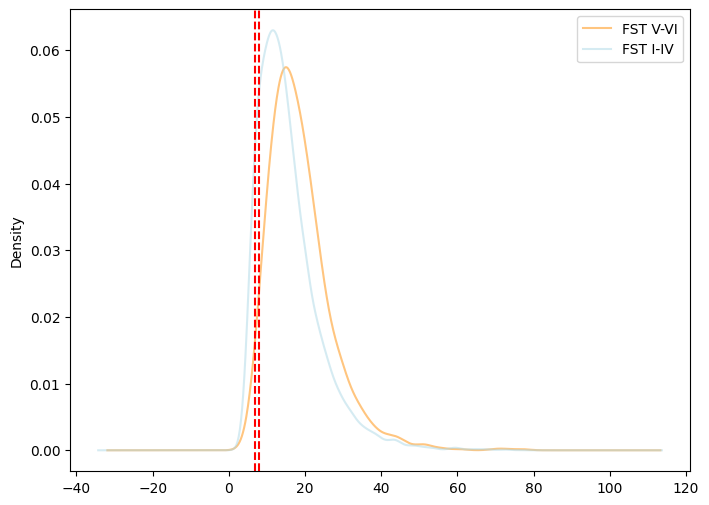

In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt


x = np.arange(0, 100)

# Calculate KDE for train loader
if (error_df.labels == 0).any():
    t = gaussian_kde(error_df.re[error_df.labels == 0].values)
else:
    t = None

# for dark only
if (error_df.labels == 0).any():
    f = gaussian_kde(error_df.re[error_df.labels == 2].values)
else:
    f = None

#  for light only
if (error_df.labels == 1).any():
    g = gaussian_kde(error_df.re[error_df.labels == 1].values)
else:
    g = None




fig, ax = plt.subplots(figsize=(8, 6))

# Plot KDE for train loader
if t is not None:
    df_train = error_df[error_df.labels == 0]
    #ax = df_train["re"].plot(kind="kde", ax=ax, label="ISIC", alpha=0.5, color='green')

# for dark only
if f is not None:
    df_dark = error_df[error_df.labels == 2]
    ax = df_dark["re"].plot(kind="kde", ax=ax, label="FST V-VI", alpha=0.5, color='darkorange')

# for light only
if g is not None:
    df_light = error_df[error_df.labels == 1]
    ax = df_light["re"].plot(kind="kde", ax=ax, label="FST I-IV", alpha=0.5, color='lightblue')



#if len(idxs) > 0:
    #threshold_idx = idxs[1]
    ax.axvline(x=idxs_L, color='red', linestyle='--')
    ax.axvline(x=idxs_D, color='red', linestyle='--')



ax.legend()
plt.show()


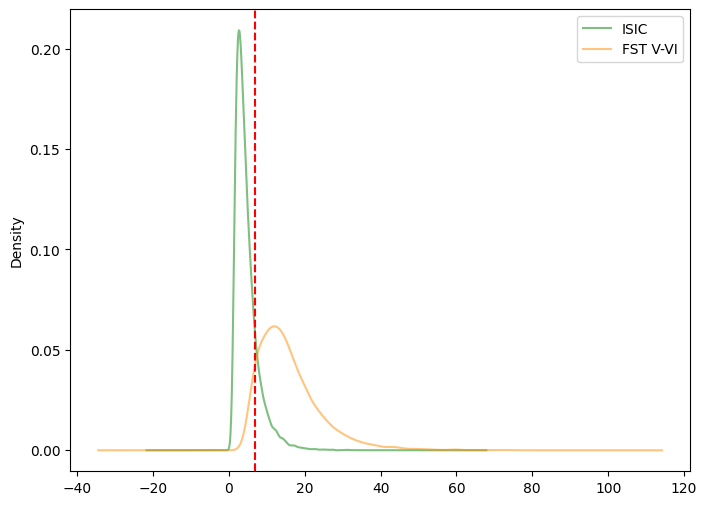

In [ ]:
#for ALL

from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt


x = np.arange(0, 100)

# Calculate KDE for train loader
if (error_df1.labels == 0).any():
    t = gaussian_kde(error_df1.re[error_df1.labels == 0].values)
else:
    t = None

# Calculate KDE for all
if (error_df1.labels == 0).any():
    f = gaussian_kde(error_df1.re[error_df1.labels == 1].values)
else:
    f = None






fig, ax = plt.subplots(figsize=(8, 6))

# Plot KDE for train loader
if t is not None:
    df_train = error_df1[error_df1.labels == 0]
    ax = df_train["re"].plot(kind="kde", ax=ax, label="ISIC", alpha=0.5, color='green')

# Plot KDE for dark only
if f is not None:
    df_all = error_df1[error_df1.labels == 1]
    ax = df_all["re"].plot(kind="kde", ax=ax, label="FST V-VI", alpha=0.5, color='darkorange')


ax.axvline(x=idxs_all, color='red', linestyle='--')




ax.legend()
plt.show()

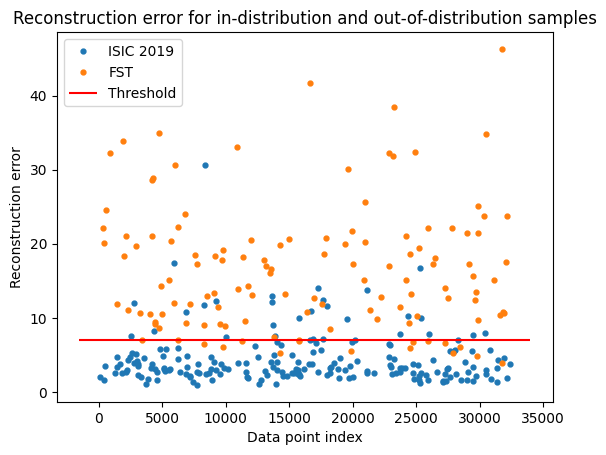

In [ ]:
#For all
import matplotlib.pyplot as plt
from aux import plot_re
plot_fraction = 0.01

sampled_error_df1 = error_df1.sample(frac=plot_fraction, random_state=42)

groups = sampled_error_df1.groupby("labels")
threshold_fixed = idxs_all

plot_re(groups, threshold_fixed)

In [ ]:
print(idxs_L)
print(idxs_D)
print(idxs_all)

[7]
[8]
[7]


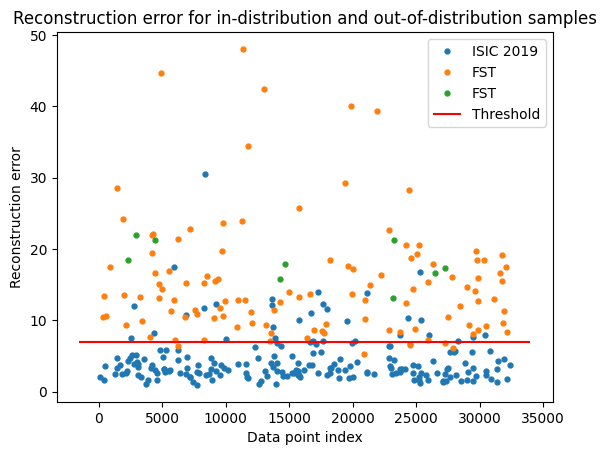

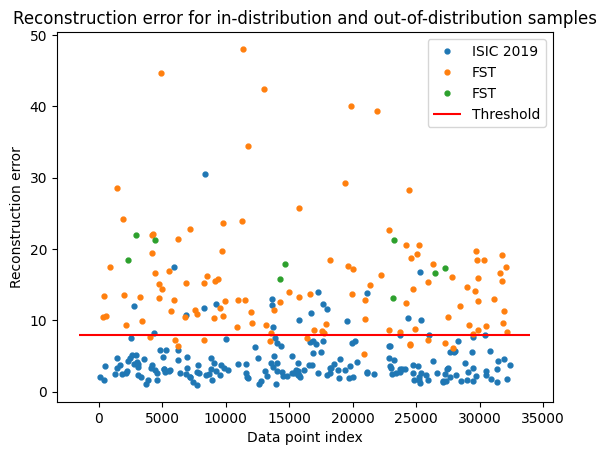

In [ ]:
import matplotlib.pyplot as plt
from aux import plot_re


plot_fraction = 0.01

sampled_error_df = error_df.sample(frac=plot_fraction, random_state=42)

groups = sampled_error_df.groupby("labels")
threshold_fixed = idxs_L

plot_re(groups, threshold_fixed)
plot_re(groups, idxs_D)

In [ ]:
threshold_fixed_L = idxs_L
threshold_fixed_D = idxs_D

def apply_threshold(x):
    if (x <= threshold_fixed_L) & (x <= threshold_fixed_D):
        return 0
    else:
        return 1


#error_df["output"] = error_df["re"].apply(lambda x: 0 if x <= threshold_fixed else 1)
error_df['output'] = error_df['re'].apply(apply_threshold)
error_df #two different datafames for darker and lighter

,re,labels,output
0,4.342609,0,0
1,4.265398,0,0
2,4.080728,0,0
3,24.960615,2,1
4,10.046871,0,1
...,...,...,...
32481,44.714958,1,1
32482,2.297856,0,0
32483,2.614737,0,0
32484,4.884062,0,0


In [ ]:
threshold_fixed_L = idxs_L
threshold_fixed_D = idxs_D

def apply_threshold(x):
    if (x <= threshold_fixed_L) & (x <= threshold_fixed_D):
        return 0
    else:
        return 1


#error_df["output"] = error_df["re"].apply(lambda x: 0 if x <= threshold_fixed else 1)
error_df['output'] = error_df['re'].apply(apply_threshold)
error_df #two different datafames for darker and lighter

,re,labels,output
0,4.342609,0,0
1,4.265398,0,0
2,4.080728,0,0
3,24.960615,2,1
4,10.046871,0,1
...,...,...,...
32481,44.714958,1,1
32482,2.297856,0,0
32483,2.614737,0,0
32484,4.884062,0,0


In [ ]:
threshold_fixed= idxs_all

def apply_threshold(x):
    if (x <= threshold_fixed):
        return 0
    else:
        return 1


#error_df["output"] = error_df["re"].apply(lambda x: 0 if x <= threshold_fixed else 1)
error_df1['output'] = error_df1['re'].apply(apply_threshold)
error_df1 #two different datafames for darker and lighter

,re,labels,output
0,4.342609,0,0
1,4.265398,0,0
2,4.080728,0,0
3,4.513561,1,0
4,10.046871,0,1
...,...,...,...
32481,19.749836,1,1
32482,2.297856,0,0
32483,2.614737,0,0
32484,4.884062,0,0


### Plotting the histogram

In [ ]:
re_Lighter = error_df[(error_df['labels'] == 1) & (error_df['output'] == 1)]['re']
re_Darker = error_df[(error_df['labels'] == 2) & (error_df['output'] == 1)]['re']
re_Inlier = error_df[(error_df['labels'] == 0) & (error_df['output'] == 0)]['re']

# Print counts
print("Count of lighter:", len(re_Lighter))
print("Count of darker:", len(re_Darker))
print("Count of inlier:", len(re_Inlier))

Count of lighter: 9974
Count of darker: 1296
Count of inlier: 16935


In [ ]:

re_Lighter = error_df[(error_df['labels'] == 1) & (error_df['output'] == 1)]['re']
re_Darker = error_df[(error_df['labels'] == 2) & (error_df['output'] == 1)]['re']
re_Inlier = error_df[(error_df['labels'] == 0) & (error_df['output'] == 0)]['re']

print("Count of lighter:", len(re_Lighter))
print("Count of darker:", len(re_Darker))
print("Count of inlier:", len(re_Inlier))

Count of lighter: 9974
Count of darker: 1296
Count of inlier: 16935


In [ ]:

re_Lighter_all = error_df[(error_df['labels'] == 1) ]['re']
re_Darker_all = error_df[(error_df['labels'] == 2) ]['re']
re_Inlier_all = error_df[(error_df['labels'] == 0) ]['re']


print("Count of re lighter without threshold:", len(re_Lighter_all))
print("Count of re darker without threshold:", len(re_Darker_all))
print("Count of re inlier without threshold:", len(re_Inlier_all))

Count of re lighter without threshold: 10904
Count of re darker without threshold: 1318
Count of re inlier without threshold: 20264


In [ ]:

re_Lighter_bellow = error_df[(error_df['labels'] == 1) & (error_df['output'] == 0) ]['re']
re_Darker_bellow = error_df[(error_df['labels'] == 2)& (error_df['output'] == 0) ]['re']
re_Inlier_bellow = error_df[(error_df['labels'] == 0) &(error_df['output'] == 1) ]['re']

print("Count of re lighter bellow threshold:", len(re_Lighter_bellow))
print("Count of re darker bellow threshold:", len(re_Darker_bellow))
print("Count of re inlier above threshold:", len(re_Inlier_bellow))

Count of re lighter bellow threshold: 930
Count of re darker bellow threshold: 22
Count of re inlier above threshold: 3329


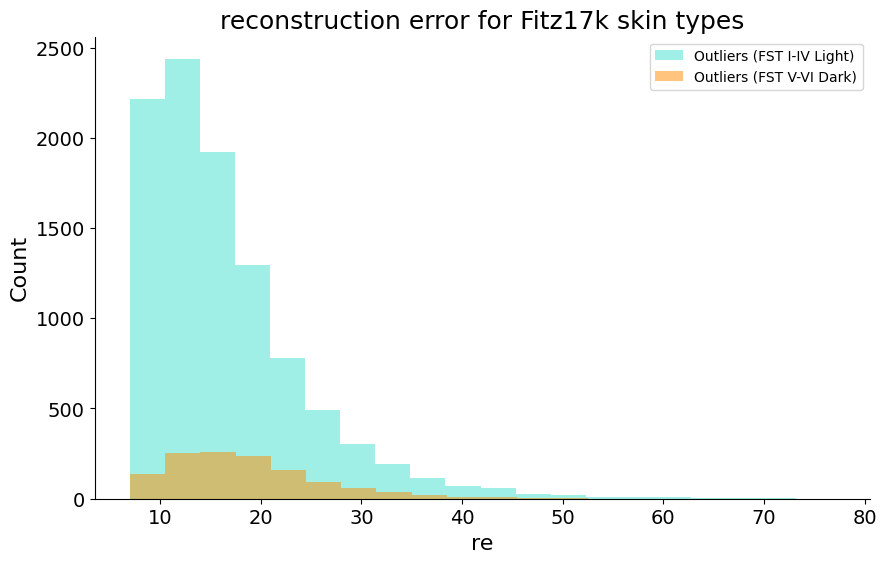

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.hist(abs(re_Lighter), bins=20, alpha=0.5, color="turquoise", label="Outliers (FST I-IV Light)")
plt.hist(abs(re_Darker), bins=20, alpha=0.5, color="darkorange", label="Outliers (FST V-VI Dark)")



plt.xlabel("re",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.legend()
plt.title("reconstruction error for Fitz17k skin types",fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Show the plot
plt.show()


plotting re bellow threshold

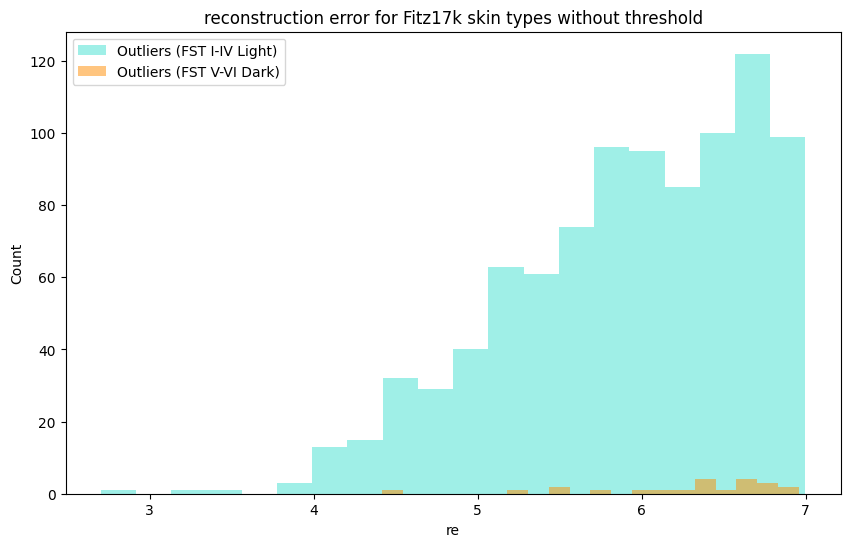

In [ ]:
import matplotlib.pyplot as plt





# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(abs(re_Lighter_bellow), bins=20, alpha=0.5, color="turquoise", label="Outliers (FST I-IV Light)")
plt.hist(abs(re_Darker_bellow), bins=20, alpha=0.5, color="darkorange", label="Outliers (FST V-VI Dark)")

# Add titles and labels
plt.title("Score Histograms for Different Categories")
plt.xlabel("re")
plt.ylabel("Count")
plt.legend()
plt.title("reconstruction error for Fitz17k skin types without threshold")
plt.show()